<a href="https://colab.research.google.com/github/luthra2059/Handwritten-Image-Classification-using-Tensorflow-Lite/blob/master/Hand_Written_image_classifier_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
print(tf.__version__)

2.2.0


In [3]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
train_images = train_images/255.0
test_images = test_images/255.0
print("Pixels are normalized")

Pixels are normalized


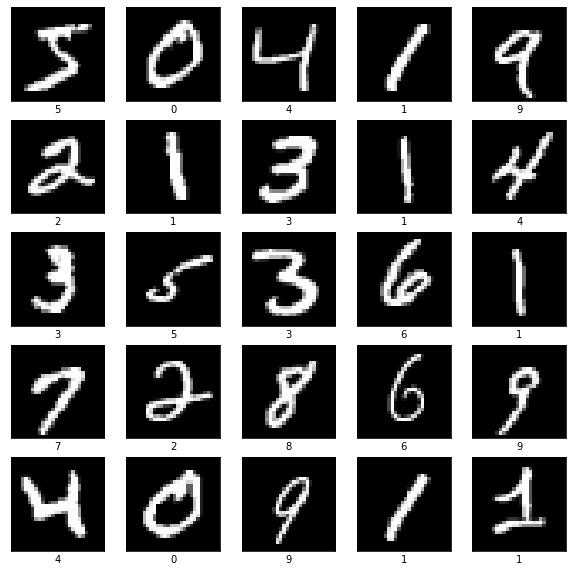

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [6]:
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 134s 71ms/step - loss: 0.1467 - accuracy: 0.9564
Epoch 2/5
1875/1875 [==============================] - 134s 71ms/step - loss: 0.0544 - accuracy: 0.9833
Epoch 3/5
1875/1875 [==============================] - 138s 74ms/step - loss: 0.0400 - accuracy: 0.9880
Epoch 4/5
1875/1875 [==============================] - 134s 71ms/step - loss: 0.0293 - accuracy: 0.9908
Epoch 5/5
1875/1875 [==============================] - 133s 71ms/step - loss: 0.0250 - accuracy: 0.9920


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                9

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 6s 20ms/step - loss: 0.0374 - accuracy: 0.9886
Test accuracy: 0.9886000156402588


In [9]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

In [10]:
predictions = model.predict(test_images)

In [13]:
prediction_digits = np.argmax(predictions, axis=1)

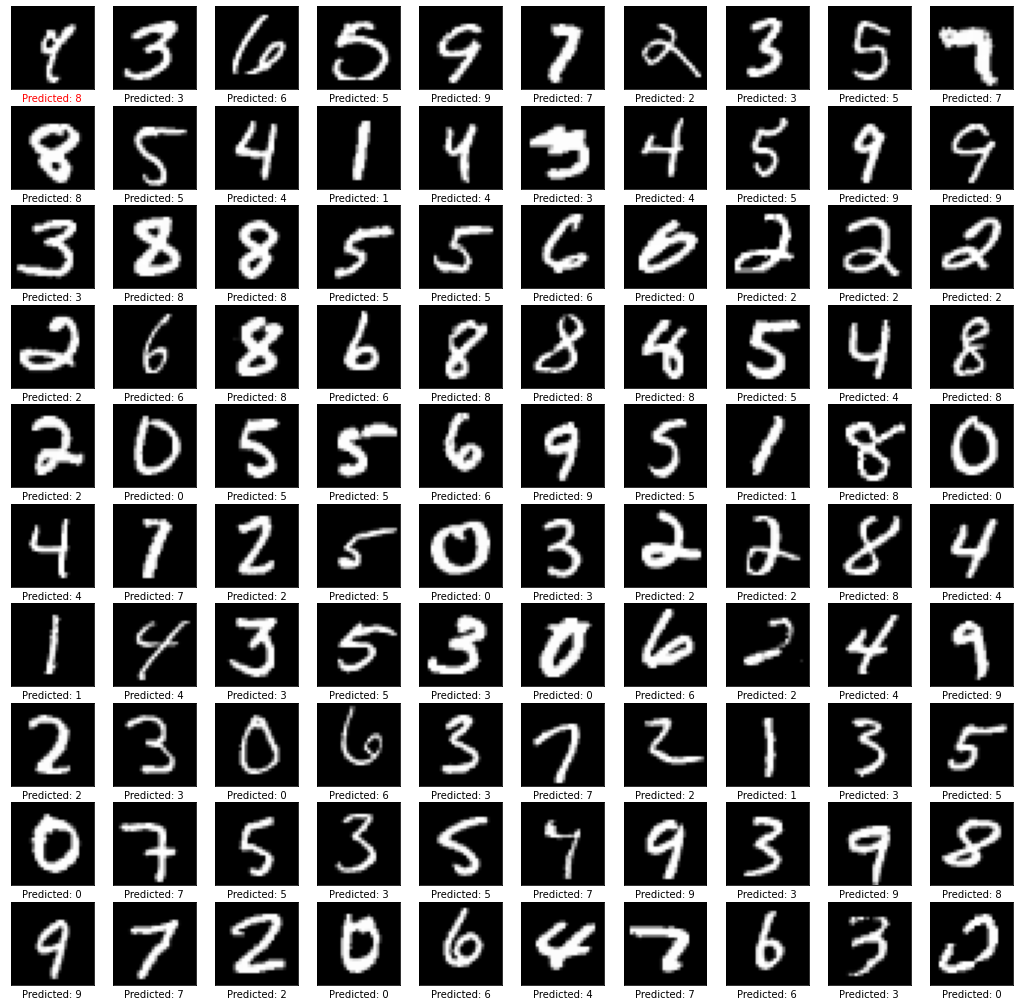

In [14]:
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

In [16]:
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 435KBs.


In [17]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

In [18]:
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 111KBs,
which is about 25% of the float model size.


In [19]:
def evaluate_tflite_model(tflite_model):
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  prediction_digits = []
  for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    interpreter.invoke()

    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.9886
Quantized model accuracy = 0.9886
Accuracy drop = 0.0000


In [20]:
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

In [21]:
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')

`mnist.tflite` has been downloaded
